### Comments

**TO DO**
* Batch?!
* fine tuning des params --> pas optimisé pour le moment
* try different architecture
* Use genre as features and build network on Cast, Crew, Keywords?
* Skip Connections ? Batch Norm ? 

# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, recall_score
from sklearn.utils import resample
from sklearn.decomposition import PCA

import random

import dgl.function as fn
from dgl import DGLGraph
import dgl.nn.pytorch as dgl_nn
import dgl.transform as dgl_transform

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

Data_path = 'Data/'

### Loading the similarity matrix and generate graph

In [38]:
# Load similarity matrix
#file = open(Data_path + 'Adjacency_matrix.pickle','rb')
#file = open(Data_path + 'Adjacency_matrix_Genre099_CC005.pickle', 'rb')
file = open(Data_path + 'Adjacency_matrix_G99CCK05.pickle', 'rb')
adj_mat =  pickle.load(file)

# Generate graph
G = DGLGraph(graph_data=adj_mat)
G = dgl_transform.add_self_loop(G)

### Loading features and labels

In [3]:
features_df = pd.read_csv(Data_path + 'features.csv',index_col=0).drop(columns = ['title'])

labels_df = pd.read_csv(Data_path + 'labels.csv',index_col=0).drop(columns = ['title', ])

keep only some features

In [ ]:
#features_df = features_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

The labels is whether the movie is nominated for an Oscare or a GoldenGlobes 

In [ ]:
#labels_df['Nominations'] = labels_df['Nominations_Oscars'] + labels_df['Nominations_GoldenGlobes']

In [5]:
# features
tensor_data = torch.FloatTensor(features_df.values)

# labels
IMDB_nom = labels_df['Nominations'].copy()
IMDB_nom.loc[IMDB_nom > 0] = 1
tensor_labels = torch.LongTensor(IMDB_nom.values)

In [6]:
# Just checking class imbalance
IMDB_nom.value_counts() # 18.263 % of CLASS 1

0.0    3728
1.0    1074
Name: Nominations, dtype: int64

In [ ]:
'''# Separate majority and minority classes
df_majority = IMDB_nom[IMDB_nom==0]
df_minority = IMDB_nom[IMDB_nom==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=877,     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

adj_mat_bal = adj_mat[df_downsampled.index,:]
adj_mat_bal = adj_mat_bal[:,df_downsampled.index]
G = DGLGraph(graph_data=adj_mat_bal)

G = dgl_transform.add_self_loop(G)

tensor_feat = torch.FloatTensor(features_df.iloc[df_downsampled.index,:].values)
tensor_labels = torch.LongTensor(df_downsampled.values)'''

### Generate masks and split train, val, test

In [ ]:
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)

for prov_index, test_index in sss1.split(tensor_data, tensor_labels):
    prov_mask = prov_index
    test_mask = test_index

for train_index, val_index in sss2.split(tensor_data[prov_mask], tensor_labels[prov_mask]):
    train_mask = train_index
    val_mask = val_index

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)
#sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)

for prov_index, test_index in sss.split(tensor_data, tensor_labels):
    train_mask = prov_index
    val_mask = test_index

#for train_index, val_index in sss1.split(tensor_feat[prov_mask], tensor_labels[prov_mask]):
#    train_mask = train_index
#    val_mask = val_index

### Building Graph Neural Network

In [49]:
#  model: Combine GraphConv layers first then two fully connected layers --> seems less stable over epochs
class Linear_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.linear = nn.Linear(self._in_feats, 32)
        self.gcn1 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.linear1 = nn.Linear(32, self._out_feats)#self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = F.relu(self.linear(feat))
        h = self.gcn1(graph, h)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.linear1(h)
        #h = F.relu(h)
        #h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

# Model : Only GraphConv layers --> seems more stable
class Pure_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.gcn1 = dgl_nn.conv.GraphConv(self._in_feats, 32, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(32, self._out_feats, activation=None)
        
    def forward(self, graph, feat):
        h = self.gcn1(graph, feat)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = F.log_softmax(h, dim=1)
        return h 

# model : Use and APPNP layer with k=7 (the network diameter) followed by 2 fully connected linears. 
class Simple_APPNP(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int, k: int):
        super().__init__()
        self._k = k
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.appnpconv1 = dgl_nn.conv.APPNPConv(self._k, 0.1, 0) #alpha teleport proba = 0.1 (cf paper)
        self.linear1 = nn.Linear(self._in_feats, self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = self.appnpconv1(graph, feat)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

In [50]:
def train(model, g, features, labels, train_mask, loss_fcn, optimizer):
    """ TO DO : add doctring """
    model.train()  
    
    pred = model(g, features) # prediction
    loss = loss_fcn(pred[train_mask], tensor_labels[train_mask])
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, mask, labels):
    """  TO DO : add docstring """
    model.eval()  
    
    with torch.no_grad():
        pred = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(pred, dim=1)
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels) #not the best metric
        f1 = f1_score(labels, indices)
        
        return f1, acc

In [34]:
# check network diameter --> take a lot of time to run 
import networkx as nx
Gnx = nx.from_numpy_array(adj_mat)
G_large = max(nx.connected_component_subgraphs(Gnx), key=len)
#d = nx.diameter(G_large) 
#print(f'diameter : {d}')

6

In [51]:
# Fixed values
in_feats = tensor_data.shape[1]
out_feats = 2

# Not relevant parameters
n_epochs = 400
# To tune
k = 6 # number of hop (how far to look) usually best to use the network diameter (according to paper)
lr = 5e-5
weight_decay = 5e-6
#p_dropout = 0 # for now not doing it

hidden_size = 128
true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance

Epoch 10 | Train Loss 4522.606 | Val f1 6.8027% | Val Accuracy 71.4880%
Epoch 20 | Train Loss 2887.347 | Val f1 31.1734% | Val Accuracy 59.1051%
Epoch 30 | Train Loss 2741.296 | Val f1 36.1149% | Val Accuracy 51.4048%
Epoch 40 | Train Loss 2571.076 | Val f1 37.3333% | Val Accuracy 51.0926%
Epoch 50 | Train Loss 2369.465 | Val f1 35.7243% | Val Accuracy 52.4454%
Epoch 60 | Train Loss 2225.104 | Val f1 33.2317% | Val Accuracy 54.4225%
Epoch 70 | Train Loss 2108.841 | Val f1 33.8509% | Val Accuracy 55.6712%
Epoch 80 | Train Loss 1991.233 | Val f1 34.2772% | Val Accuracy 54.1103%
Epoch 90 | Train Loss 1863.891 | Val f1 34.8083% | Val Accuracy 54.0062%
Epoch 100 | Train Loss 1763.762 | Val f1 35.2410% | Val Accuracy 55.2549%
Epoch 110 | Train Loss 1669.108 | Val f1 34.7958% | Val Accuracy 55.1509%
Epoch 120 | Train Loss 1572.264 | Val f1 34.8092% | Val Accuracy 55.5671%
Epoch 130 | Train Loss 1458.847 | Val f1 34.9776% | Val Accuracy 54.7347%
Epoch 140 | Train Loss 1298.661 | Val f1 35.9352

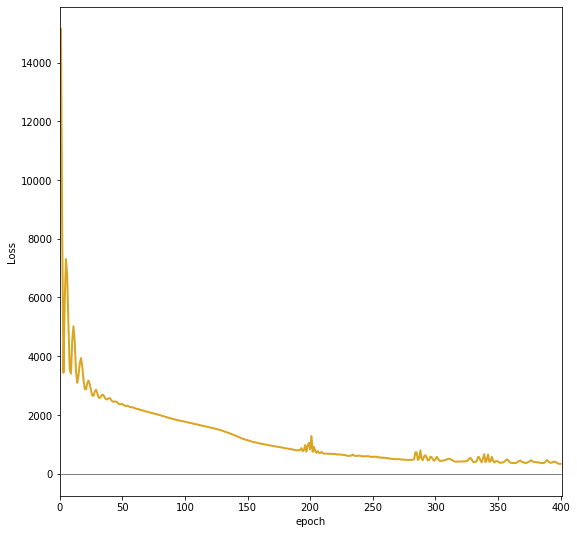

In [52]:
model = Linear_GNN(in_feats, out_feats, hidden_size)
#model = Simple_APPNP(in_feats, out_feats, hidden_size, k)

loss_fcn = torch.nn.NLLLoss(weight=weights_loss)
optimizer = torch.optim.Adam(model.parameters(),
                                                  lr=lr)
                                                  #weight_decay=weight_decay)
losses = []
for epoch in range(n_epochs):
    
    loss = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
    losses.append(loss.item())
    f1, acc = evaluate(model, G, tensor_data, val_mask, tensor_labels)
    
    if (1+epoch)%10 == 0:
        print(f"Epoch {epoch+1} | Train Loss {loss.item():.3f} | Val f1 {f1:.4%} | Val Accuracy {acc:.4%}")

#print()
#f1, acc = evaluate(model, G, tensor_feat, test_mask, tensor_labels)
#print("Test Accuracy {:.4%}".format(acc))

# Plot the loss
fig, ax = plt.subplots(1,1,figsize=(9,9))
ep = np.arange(1,n_epochs+1,1)
ax.plot(ep, losses, color='Goldenrod', linewidth=2)
ax.plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
ax.set_xlim([0,n_epochs+1])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
plt.show()